<a href="https://colab.research.google.com/github/AP-047/RClass-Classification-by-Rational-Approximation/blob/main/notebooks/multi_dimensional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Set Locale to UTF-8**

In [ ]:
!apt-get install -y locales
!locale-gen en_US.UTF-8
!update-locale LANG=en_US.UTF-8

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
locales is already the newest version (2.35-0ubuntu3.8).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Generating locales (this might take a while)...
  en_US.UTF-8... done
Generation complete.


**Upgrade setuptools and pip**

In [ ]:
!pip install -U setuptools pip

**Install CuPy for CUDA 12.2**

In [ ]:
!pip install cupy-cuda12x

**4D**

In [ ]:
# import cupy as cp
# import numpy as np

# x_data = cp.array([[1, 2, 3, 4], [3, 4, 5, 6], [2, 4, 5, 3], [3, 4, 1, 6]])
# num_data_points =  x_data.shape[0]
# num_coefficients = 4+1

# G = cp.zeros((num_data_points, num_coefficients))

# for i in range(num_data_points):
#     G[i, 0] = 1
#     for j in range(num_coefficients-1):
#         G[i, j+1] = x_data[i, j] ** (j+1)

# print(f"G: {G}")

G: [[1.000e+00 1.000e+00 4.000e+00 2.700e+01 2.560e+02]
 [1.000e+00 3.000e+00 1.600e+01 1.250e+02 1.296e+03]
 [1.000e+00 2.000e+00 1.600e+01 1.250e+02 8.100e+01]
 [1.000e+00 3.000e+00 1.600e+01 1.000e+00 1.296e+03]]


In [8]:
import cupy as cp
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

# Target function (|x1 + x2 + x3 + x4 - 0.1|)
def target_function(x):
    return cp.abs(x[:, 0] + x[:, 1] + x[:, 2] + x[:, 3] - 0.1)

def rational_function(x, alpha, beta):
    """
    r(x) = (α_0 + α_1*x1**1 + α_2*x2**2 + α_3*x3**3 + α_4*x4**4) /
           (β_0 + β_1*x1**1 + β_2*x2**2 + β_3*x3**3 + β_4*x4**4)
    """
    # Ensure x is treated as a 1D vector when passed for a single data point
    x = cp.asarray(x)  # Convert to CuPy array
    # Numerator polynomial
    numerator = alpha[0] + alpha[1] * x[0]**1 + alpha[2] * x[1]**2 + alpha[3] * x[2]**3 + alpha[4] * x[3]**4
    # Denominator polynomial
    denominator = beta[0] + beta[1] * x[0]**1 + beta[2] * x[1]**2 + beta[3] * x[2]**3 + beta[4] * x[3]**4

    return numerator / denominator

delta = 1e-6  # a small positive value

# Feasibility check function
def check_feasibility_and_compute_coefficients(z, x_data, y_data):
    num_data_points = x_data.shape[0]
    num_coefficients = 4+1  # (1 constant term + 4 variables)

    # Construct G(x) and H(x) matrices for numerator and denominator
    G = cp.zeros((num_data_points, num_coefficients))  # Numerator matrix
    H = cp.zeros((num_data_points, num_coefficients))  # Denominator matrix

    # for i in range(num_data_points):
    #     G[i, 0] = 1  # Constant term
    #     H[i, 0] = 1  # Constant term
    #     for j in range(0, num_coefficients):  # Variables with increasing powers
    #         G[i, j] = x_data[i, j - 1] ** j
    #         H[i, j] = x_data[i, j - 1] ** j

    for i in range(num_data_points):
      G[i, 0] = 1
      H[i, 0] = 1
      for j in range(num_coefficients-1):
        G[i, j+1] = x_data[i, j] ** (j+1)
        H[i, j+1] = x_data[i, j] ** (j+1)

    # print(f"G: {G}")
    # print(f"H: {H}")

    # Construct constraints for Ax <= b
    A = []
    b = []

    for i in range(num_data_points):
        f_plus_z = y_data[i] + z  # Upper bound
        f_minus_z = y_data[i] - z  # Lower bound

        # Constraint 1: (f(xi) - z) * β^T H(xi) - α^T G(xi) ≤ θ
        # (-G(xi))αT + (f(xi) - z).H(xi)βT + (-1)θ ≤ 0
        constraint_1 = cp.zeros(2 * num_coefficients + 1)
        # (1) Coefficients of α
        constraint_1[0:num_coefficients] = -G[i]
        # (2) Coefficients of β
        constraint_1[num_coefficients:2 * num_coefficients] = (f_minus_z) * H[i]
        # (3) Coefficient of θ (last element)
        constraint_1[-1] = -1
        A.append(constraint_1)
        b.append(0)

        # Constraint 2: α^T G(xi) + (-1).(f(xi) + z) * β^T H(xi) ≤ θ
        # G(xi).αT + (-1)(f(xi) - z).H(xi)βT + (-1)θ ≤ 0
        constraint_2 = cp.zeros(2 * num_coefficients + 1)
        # (1) Coefficients of α
        constraint_2[0:num_coefficients] = G[i]
        # (2) Coefficients of β
        constraint_2[num_coefficients:2 * num_coefficients] = -(f_plus_z) * H[i]
        # (3) Coefficient of θ (last element)
        constraint_2[-1] = -1
        A.append(constraint_2)
        b.append(0)

        # Constraint 3: β^T H(x) ≥ δ
        # (0)α^T + (-H(x)) β^T + (0)θ ≤ -δ
        constraint_3 = cp.zeros(2 * num_coefficients + 1)
        # Coefficient of β
        constraint_3[num_coefficients:2 * num_coefficients] = -H[i]
        A.append(constraint_3)
        b.append(-delta)

    # Convert CuPy arrays to NumPy arrays for SciPy
    A = cp.asnumpy(cp.array(A))
    b = cp.asnumpy(cp.array(b))

    # print(f"A =", len(A))
    # print(f"A: {A[0]}")

    # print(f"len(A[0]): {len(A[0])}")
    # print(f"len(b): {len(b)}")

    #for linprog API -
    # Objective function to minimize θ
    c = cp.asnumpy(cp.zeros(2 * num_coefficients + 1))
    c[-1] = 1  # Only θ has a coefficient in the objective function

    # Solve the linear programming problem
    result = linprog(c, A_ub=A, b_ub=b, method="highs")

    # Check feasibility and return results
    if result.success:
        alpha_coefficients = result.x[:num_coefficients]
        beta_coefficients = result.x[num_coefficients:2 * num_coefficients]
        theta = result.x[-1]
        return True, alpha_coefficients, beta_coefficients, theta
    else:
        return False, None, None, None


# Bisection loop
def bisection_loop(x_data, y_data, uL, uH, precision):
    optimal_alpha, optimal_beta, optimal_theta = None, None, None
    z_values = []

    while uH - uL > precision:
        z = (uL + uH) / 2
        z_values.append(z)
        feasible, alpha_coefficients, beta_coefficients, theta = check_feasibility_and_compute_coefficients(z, x_data, y_data)

        if feasible:
            uH = z
            optimal_alpha, optimal_beta, optimal_theta = alpha_coefficients, beta_coefficients, theta
        else:
            uL = z

    return uH, optimal_alpha, optimal_beta, optimal_theta, z_values

def generate_well_distributed_dataset(num_samples, value_range):
    # Use NumPy to generate a grid of values
    import numpy as np
    from itertools import product

    # Create a grid of possible values
    grid = np.linspace(value_range[0], value_range[1], int(num_samples ** (1/4)))  # Divide num_samples into 4 dimensions
    combinations = list(product(grid, repeat=4))  # Cartesian product for 4 dimensions

    # Convert to NumPy array and shuffle
    dataset = np.array(combinations)
    np.random.shuffle(dataset)  # Shuffle to avoid any patterns

    # Take the first num_samples samples and convert to CuPy array
    return cp.array(dataset[:num_samples])


# Main execution
if __name__ == "__main__":
    # # Data setup
    # x_data = cp.array([[1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6], [2, 4, 5, 3], [3, 4, 1, 6], [4, 3, 6, 2], [2, 6, 1, 3], [2, 3, 5, 6], [3, 2, 4, 3], [3, 1 ,2, 1]])
    x_data = cp.array([[1, 2, 0, 1], [1, 0, 0, 2], [0, 1, 1, 0], [1, 1, 1, 0], [0, 2, 1, 1], [1, 0, 2, 0], [1, 1, 0, 0], [1, 1, 2, 1], [0, 2, 0, 1], [1, 0, 0, 1], [1, 2, 0, 1]])
    # x_data = cp.array([[1, 1, 0, 1], [1, 0, 0, 1], [0, 1, 1, 0], [1, 1, 1, 0], [0, 0, 1, 1], [1, 0, 1, 0], [1, 1, 0, 0], [1, 1, 1, 1], [0, 1, 0, 1], [1, 0, 0, 1], [1, 0, 0, 1]])
    y_data = target_function(x_data)


    #--------
    # # a well-distributed dataset
    # num_samples = 16  # Total number of data points
    # value_range = (0, 1)  # Range for each value in the vector
    # x_data = generate_well_distributed_dataset(num_samples, value_range)

    # # Compute the target values
    # y_data = target_function(x_data)
    #--------

    # Bisection parameters
    uL = 0  # Initial lower bound
    uH = 50  # Initial upper bound
    precision = 1e-6  # Precision threshold

    # Run bisection loop
    optimal_z, optimal_alpha, optimal_beta, optimal_theta, z_values = bisection_loop(x_data, y_data, uL, uH, precision)

    # Print results
    print(f"Number of Iterations: {len(z_values)}")
    print(f"z Values in all Iterations: {z_values}")
    print(f"Optimal z (Maximum Deviation): {optimal_z}")

    # # Plot convergence of z values
    # plt.figure(figsize=(8, 6))
    # plt.plot(range(len(z_values)), z_values, marker='o', linestyle='-')
    # plt.xlabel("Iteration")
    # plt.ylabel("z Value")
    # plt.title("Convergence of z Values")
    # plt.grid(True)
    # plt.show()

    print(f"Optimized Coefficients (Numerator α): {optimal_alpha}")
    print(f"Optimized Coefficients (Denominator β): {optimal_beta}")
    print(f"Optimal θ: {optimal_theta}")
    print(f"rational_function =", rational_function(x_data[0], optimal_alpha, optimal_beta))

Number of Iterations: 26
z Values in all Iterations: [25.0, 12.5, 6.25, 3.125, 1.5625, 0.78125, 0.390625, 0.1953125, 0.09765625, 0.048828125, 0.0244140625, 0.01220703125, 0.006103515625, 0.0030517578125, 0.00152587890625, 0.000762939453125, 0.0003814697265625, 0.00019073486328125, 9.5367431640625e-05, 4.76837158203125e-05, 2.384185791015625e-05, 1.1920928955078125e-05, 5.9604644775390625e-06, 2.9802322387695312e-06, 1.4901161193847656e-06, 7.450580596923828e-07]
Optimal z (Maximum Deviation): 7.450580596923828e-07
Optimized Coefficients (Numerator α): [3.25000000e-07 1.00000000e-06 7.50000000e-07 2.66666667e-07
 1.33333333e-07]
Optimized Coefficients (Denominator β): [1.e-06 0.e+00 0.e+00 0.e+00 0.e+00]
Optimal θ: 5.583325882752735e-07
rational_function = 4.458333333333333


**Testing**

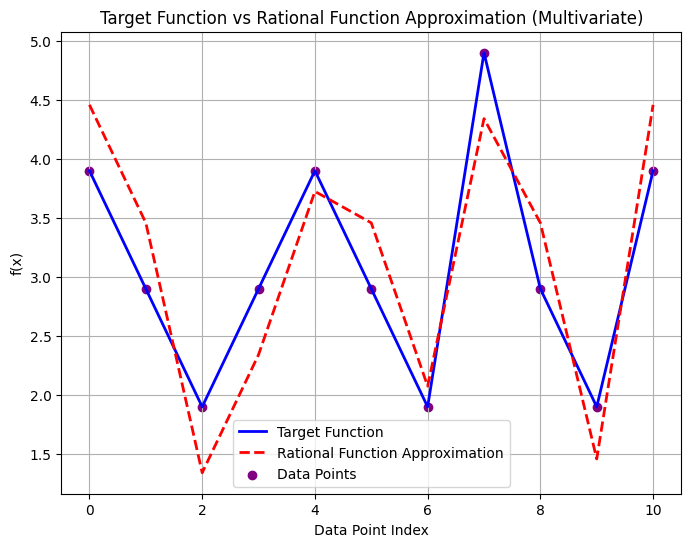

     Data Points  Target Function Values  Rational Function Values  \
0   [1, 2, 0, 1]                     3.9                  4.458333   
1   [1, 0, 0, 2]                     2.9                  3.458333   
2   [0, 1, 1, 0]                     1.9                  1.341667   
3   [1, 1, 1, 0]                     2.9                  2.341667   
4   [0, 2, 1, 1]                     3.9                  3.725000   
5   [1, 0, 2, 0]                     2.9                  3.458333   
6   [1, 1, 0, 0]                     1.9                  2.075000   
7   [1, 1, 2, 1]                     4.9                  4.341667   
8   [0, 2, 0, 1]                     2.9                  3.458333   
9   [1, 0, 0, 1]                     1.9                  1.458333   
10  [1, 2, 0, 1]                     3.9                  4.458333   

    Absolute Error  Relative Error  
0         0.558333        0.143162  
1         0.558333        0.192529  
2         0.558333        0.293860  
3         0

In [9]:
def plot_functions_multivariate(target_function, rational_function, alpha, beta, x_data):
    # Compute function values for the provided x_data
    y_target = target_function(x_data)  # Compute the target function values
    y_rational = cp.array([rational_function(x, alpha, beta) for x in x_data])  # Compute rational function values

    # Convert CuPy arrays to NumPy for plotting
    x_indices = range(len(x_data))  # Use indices as x-axis for simplicity
    y_target = cp.asnumpy(y_target)
    y_rational = cp.asnumpy(y_rational)

    # Plot the functions
    plt.figure(figsize=(8, 6))
    plt.plot(x_indices, y_target, label="Target Function", color="blue", linewidth=2)
    plt.plot(x_indices, y_rational, label="Rational Function Approximation", color="red", linestyle="--", linewidth=2)
    plt.scatter(x_indices, y_target, label="Data Points", color="purple", marker="o")
    plt.xlabel("Data Point Index")
    plt.ylabel("f(x)")
    plt.title("Target Function vs Rational Function Approximation (Multivariate)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution for plotting
if __name__ == "__main__":
    # Call the plotting function for the given x_data
    plot_functions_multivariate(target_function, rational_function, optimal_alpha, optimal_beta, x_data)

import pandas as pd

def generate_table(x_data, target_function, rational_function, alpha, beta):
    # Compute target and rational function values
    target_values = target_function(x_data)
    rational_values = cp.array([rational_function(x, alpha, beta) for x in x_data])

    # Calculate errors
    absolute_error = cp.abs(target_values - rational_values)
    relative_error = cp.abs((target_values - rational_values) / target_values)

    # Convert to NumPy for table creation
    x_data_np = cp.asnumpy(x_data)
    target_values_np = cp.asnumpy(target_values)
    rational_values_np = cp.asnumpy(rational_values)
    absolute_error_np = cp.asnumpy(absolute_error)
    relative_error_np = cp.asnumpy(relative_error)

    # Create a pandas DataFrame for better visualization
    table_data = {
        "Data Points": [list(row) for row in x_data_np],
        "Target Function Values": target_values_np,
        "Rational Function Values": rational_values_np,
        "Absolute Error": absolute_error_np,
        "Relative Error": relative_error_np,
    }
    df = pd.DataFrame(table_data)

    # Display the table
    print(df)
    return df

if __name__ == "__main__":
    # Generate the table
    df = generate_table(x_data, target_function, rational_function, optimal_alpha, optimal_beta)